In [1]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

In [2]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

# Crime 2020 Data

In [3]:
Crime2020 = gpd.read_file("Data\clean_data\complaint2020Count\complaint2020Count.shp")

Crime2020['ZIPCODE'] = Crime2020['ZIPCODE'].astype(int)
Crime2020['date'] = pd.to_datetime(Crime2020['date'])

Crime2020['Month'] = Crime2020['date'].dt.month
Crime2020['DOW'] = Crime2020['date'].dt.dayofweek
Crime2020.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2020-03-01,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,6
1,2020-03-02,83,1,0,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
2,2020-03-04,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
3,2020-03-07,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
4,2020-03-10,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1


In [4]:
Crime2020DOW = Crime2020.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2020DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1370,6382,10122,1000,132,19006,47490.788562,3060
1,1,1529,6270,9910,1095,153,18957,47433.737651,3057
2,2,1542,5944,9064,1223,161,17934,48110.668416,2859
3,3,1529,5698,8616,1181,153,17177,47868.998949,2855
4,4,1478,6155,8993,1211,175,18012,47278.700516,2905
5,5,1356,6406,8248,925,187,17122,47589.152637,2863
6,6,1265,6627,8280,874,223,17269,47585.707591,3030


(0.0, 25000.0)

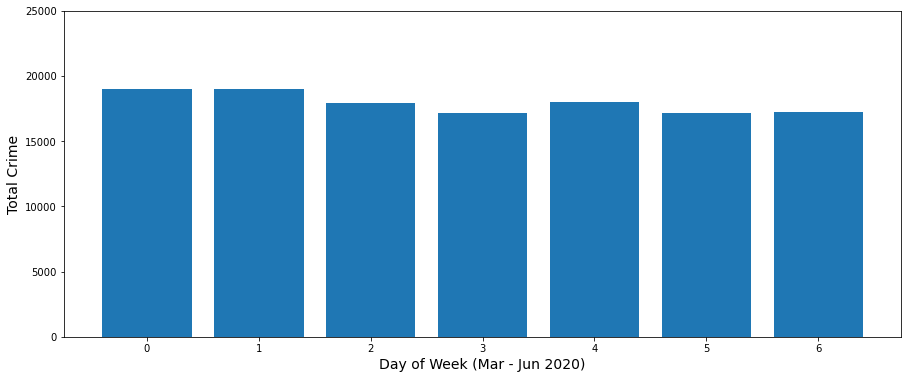

In [5]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2020DOW.DOW, Crime2020DOW.total)
plt.xticks(Crime2020DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2020)', fontsize=14)

plt.ylim([0, 25000])

In [6]:
Crime2020Month = Crime2020.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2020Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,2810,11596,16550,2183,371,33510,47259.368770,5277
1,4,2136,8515,13336,1337,210,25534,48632.475143,4908
2,5,2922,11145,16291,2392,330,33080,47604.352528,5262
3,6,2201,12226,17056,1597,273,33353,47037.480702,5182


(0.0, 40000.0)

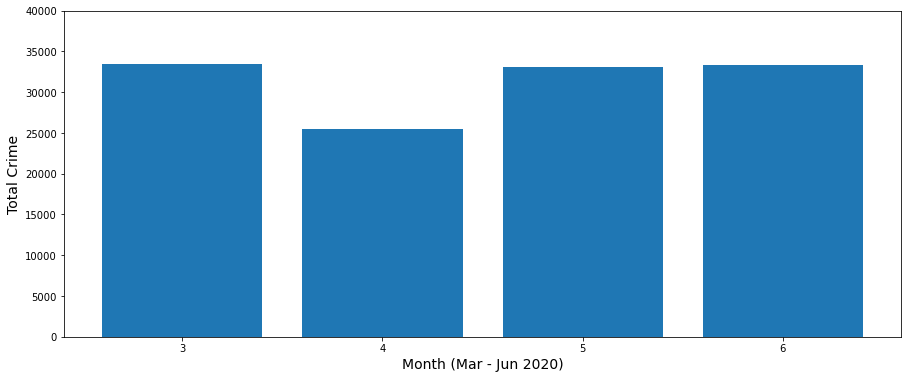

In [7]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2020Month.Month, Crime2020Month.total)
plt.xticks(Crime2020Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2020)', fontsize=14)

plt.ylim([0, 40000])

In [8]:
Crime2020grouped = Crime2020.groupby(['ZIPCODE', 'Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2020.head(10)

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2020-03-01,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,6
1,2020-03-02,83,1,0,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
2,2020-03-04,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
3,2020-03-07,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
4,2020-03-10,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1
5,2020-03-11,83,0,1,0,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
6,2020-03-12,83,0,0,3,0,0,3,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,3
7,2020-03-13,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,4
8,2020-03-14,83,0,2,0,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
9,2020-03-15,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,6


In [9]:
Crime2020grouped['TotalCrimeNorm'] = Crime2020grouped['total']/(Crime2020grouped['POPULATION']/1000)

Crime2020Apr = Crime2020grouped.loc[(Crime2020grouped['Month'] == 4 )]
Crime2020Apr

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days,TotalCrimeNorm
1,83,4,3,6,11,0,0,20,25.0,15,800.000000
5,10001,4,11,64,125,8,0,208,22413.0,30,9.280328
9,10002,4,23,104,165,11,1,304,81305.0,30,3.739007
13,10003,4,13,41,106,6,0,166,55878.0,30,2.970758
17,10004,4,8,12,28,0,0,48,2187.0,32,21.947874
...,...,...,...,...,...,...,...,...,...,...,...
733,11691,4,26,97,99,11,0,233,60267.0,30,3.866129
737,11692,4,12,44,47,2,0,105,18018.0,28,5.827506
741,11693,4,20,104,120,8,4,256,11052.0,92,23.163228
745,11694,4,5,23,20,0,1,49,20163.0,23,2.430194


In [10]:
min(Crime2020Apr['POPULATION']), max(Crime2020Apr['POPULATION'])

(0.0, 109069.0)

In [11]:
sanityindex = (Crime2020Apr['POPULATION'] > 1000)
Crime2020Apr = Crime2020Apr.loc[sanityindex]

In [12]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2020Apr['other crim'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2020Apr['personal c'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2020Apr['property c'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2020Apr['statutory'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2020Apr['traffic cr'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2020Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,0.490787,2.855486,5.577120,0.356936,0.000000
10002,0.282885,1.279134,2.029395,0.135293,0.012299
10003,0.232650,0.733741,1.896990,0.107377,0.000000
10004,3.657979,5.486968,12.802926,0.000000,0.000000
10005,0.123350,0.493401,0.863451,0.123350,0.000000
...,...,...,...,...,...
11691,0.431414,1.609504,1.642690,0.182521,0.000000
11692,0.666001,2.442002,2.608503,0.111000,0.000000
11693,1.809627,9.410062,10.857763,0.723851,0.361925


In [13]:
#from sklearn.preprocessing import StandardScaler
#scale = StandardScaler()

In [14]:
#Crime2020Apr.iloc[:,2:8]

In [15]:
#Scaled = scale.fit_transform(Crime2020Apr.iloc[:,2:8])
#Crime_ScaledApr = pd.DataFrame(Scaled, columns = Crime2020Apr.columns[2:8])


#Crime2020Apr = Crime2020Apr.reset_index(drop=True)

#Crime_ScaledApr = Crime_ScaledApr.join(Crime2020Apr.iloc[:,0:1])

#Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

#Crime_ScaledApr

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.8777072183682352
For n_clusters =3, the average silhouette_score is :0.46847230200590856
For n_clusters =4, the average silhouette_score is :0.3969833443890315
For n_clusters =5, the average silhouette_score is :0.39267816088324825
For n_clusters =6, the average silhouette_score is :0.3902546144211633
For n_clusters =7, the average silhouette_score is :0.3464168368062166
For n_clusters =8, the average silhouette_score is :0.34289301106962233
For n_clusters =9, the average silhouette_score is :0.32710945957827126
For n_clusters =10, the average silhouette_score is :0.31418703432333706
For n_clusters =11, the average silhouette_score is :0.3087999243186664
For n_clusters =12, the average silhouette_score is :0.2984126169372223
For n_clusters =13, the average silhouette_score is :0.30897401301547667
For n_clusters =14, the average silhouette_score is :0.3051284143024702
For n_clusters =15, the average silhouette_score is :0.30796374690

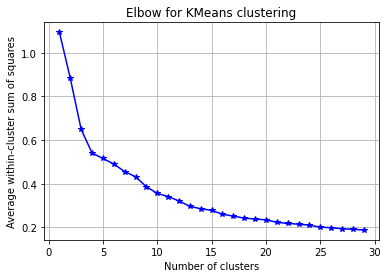

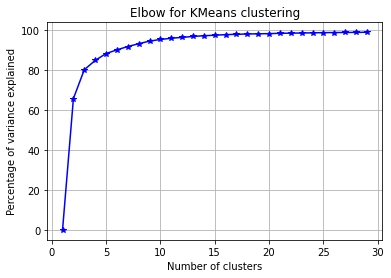

In [17]:
elbow(Crime_ScaledApr, range(1,30))

In [18]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 4, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

3

In [19]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,3
1,10002,1
2,10003,1
3,10004,0
4,10005,1
...,...,...
176,11691,3
177,11692,3
178,11693,0
179,11694,1


In [20]:
clusterCrime2020Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2020Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,0.490787,2.855486,5.577120,0.356936,0.000000,10001,3
1,0.282885,1.279134,2.029395,0.135293,0.012299,10002,1
2,0.232650,0.733741,1.896990,0.107377,0.000000,10003,1
3,3.657979,5.486968,12.802926,0.000000,0.000000,10004,0
4,0.123350,0.493401,0.863451,0.123350,0.000000,10005,1
...,...,...,...,...,...,...,...
176,0.431414,1.609504,1.642690,0.182521,0.000000,11691,3
177,0.666001,2.442002,2.608503,0.111000,0.000000,11692,3
178,1.809627,9.410062,10.857763,0.723851,0.361925,11693,0
179,0.247979,1.140703,0.991916,0.000000,0.049596,11694,1


In [21]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [22]:
clusterCrime2020AprPlot = zips.merge(clusterCrime2020Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2020AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",0.490787,2.855486,5.577120,0.356936,0.000000,3
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",0.282885,1.279134,2.029395,0.135293,0.012299,1
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",0.232650,0.733741,1.896990,0.107377,0.000000,1
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",3.657979,5.486968,12.802926,0.000000,0.000000,0
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",3.657979,5.486968,12.802926,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...
188,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",1.809627,9.410062,10.857763,0.723851,0.361925,0
189,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",1.809627,9.410062,10.857763,0.723851,0.361925,0
190,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",1.809627,9.410062,10.857763,0.723851,0.361925,0
191,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",0.247979,1.140703,0.991916,0.000000,0.049596,1


In [23]:
clusterCrime2020AprPlot['label'] = clusterCrime2020AprPlot['label'].astype(str)

clusterCrime2020AprPlot = clusterCrime2020AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2020AprPlot

,ZIPCODE,label,geometry
0,10001,3,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,1,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,1,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,0,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,0,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
188,11693,0,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
189,11693,0,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
190,11693,0,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
191,11694,1,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [24]:
clusterCrime2020AprPlot['label'] = clusterCrime2020AprPlot['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])
clusterCrime2020AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster D,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster B,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster B,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster A,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster A,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
188,11693,Cluster A,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
189,11693,Cluster A,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
190,11693,Cluster A,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
191,11694,Cluster B,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


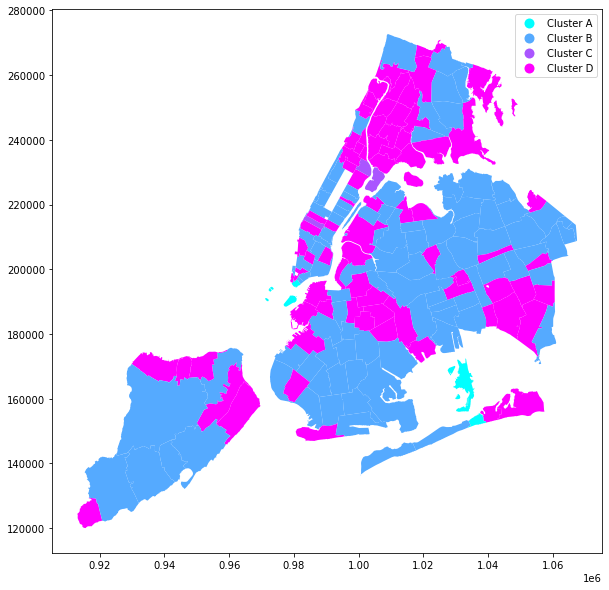

In [25]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2020AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [26]:
clusterCrime2020AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2020AprGraph = clusterCrime2020AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2020AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,5.467606,14.897030,23.660690,0.723851,0.361925,0
1,14.684892,68.262687,115.794088,6.533187,1.491456,1
2,1.729707,8.861393,18.480804,4.091065,0.057333,2
3,26.911266,102.338783,159.788314,19.004106,3.673965,3


In [27]:
clusterCrime2020AprGraph

clusterCrime2020AprGraph2 = clusterCrime2020AprGraph[[col for col in clusterCrime2020AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2020AprGraph2 = clusterCrime2020AprGraph2.div(clusterCrime2020AprGraph2.sum(axis=1), axis=0)
clusterCrime2020AprGraph2['label'] = [0,1,2,3]
clusterCrime2020AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.121203,0.330230,0.524498,0.016046,0.008023,0
1,0.071022,0.330144,0.560024,0.031597,0.007213,1
2,0.052068,0.266746,0.556311,0.123150,0.001726,2
3,0.086333,0.328307,0.512608,0.060966,0.011786,3


In [28]:
clusterCrime2020AprGraph2['label'] = clusterCrime2020AprGraph2['label'].astype(str)

clusterCrime2020AprGraph2['label'] = clusterCrime2020AprGraph2['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])

clusterCrime2020AprGraph2 = clusterCrime2020AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2020AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.121203,0.330230,0.524498,0.016046,0.008023,Cluster A
1,0.071022,0.330144,0.560024,0.031597,0.007213,Cluster B
2,0.052068,0.266746,0.556311,0.123150,0.001726,Cluster C
3,0.086333,0.328307,0.512608,0.060966,0.011786,Cluster D


In [29]:
clusterCrime2020AprGraph2.set_index('label', inplace=True)

Text(0, 0.5, 'Crime Types')

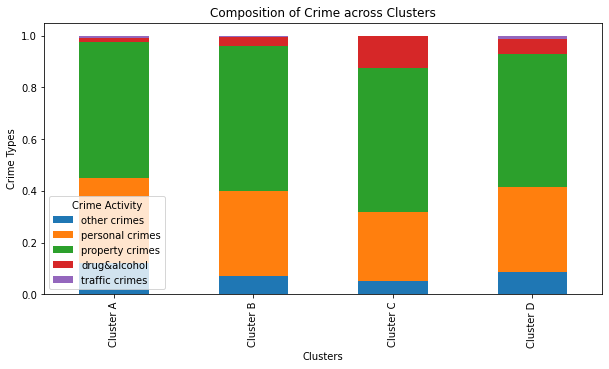

In [30]:
ax = clusterCrime2020AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")


# Crime 2017 Data

In [31]:
Crime2017 = gpd.read_file("Data\clean_data\complaint2017Count\complaint2017Count.shp")

Crime2017['ZIPCODE'] = Crime2017['ZIPCODE'].astype(int)
Crime2017['date'] = pd.to_datetime(Crime2017['date'])

Crime2017['Month'] = Crime2017['date'].dt.month
Crime2017['DOW'] = Crime2017['date'].dt.dayofweek
Crime2017.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2017-03-01,83,0,0,0,2,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
1,2017-03-03,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,4
2,2017-03-04,83,1,0,0,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
3,2017-03-06,83,0,0,2,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
4,2017-03-07,83,0,0,0,1,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1


In [32]:

Crime2017.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2017-03-01,83,0,0,0,2,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
1,2017-03-03,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,4
2,2017-03-04,83,1,0,0,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
3,2017-03-06,83,0,0,2,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
4,2017-03-07,83,0,0,0,1,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1


In [33]:
Crime2017grouped = Crime2017.groupby(['ZIPCODE', 'Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2017grouped.head(10)

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,3,3,8,10,7,0,28,25.0,16
1,83,4,5,17,25,4,1,52,25.0,24
2,83,5,7,15,29,2,1,54,25.0,26
3,83,6,6,24,39,3,0,72,25.0,27
4,10001,3,30,66,276,23,3,398,22413.0,31
5,10001,4,37,75,282,25,3,422,22413.0,30
6,10001,5,30,97,310,24,3,464,22413.0,31
7,10001,6,27,100,336,17,5,485,22413.0,30
8,10002,3,46,131,192,54,3,426,81305.0,31
9,10002,4,55,148,195,60,1,459,81305.0,30


In [34]:
Crime2017Mar = Crime2017.loc[(Crime2017['Month'] == 3 )]
Crime2017Mar

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2017-03-01,83,0,0,0,2,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
1,2017-03-03,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,4
2,2017-03-04,83,1,0,0,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
3,2017-03-06,83,0,0,2,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
4,2017-03-07,83,0,0,0,1,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21505,2017-03-14,11109,0,1,0,0,0,1,2752.0,Queens,"POLYGON ((-73.95766 40.74629, -73.95718 40.746...",3,1
21506,2017-03-18,11109,0,0,1,0,0,1,2752.0,Queens,"POLYGON ((-73.95766 40.74629, -73.95718 40.746...",3,5
21524,2017-03-19,10112,1,0,0,0,0,1,0.0,New York,"POLYGON ((-73.98089 40.75927, -73.98071 40.759...",3,6
21525,2017-03-24,10112,0,1,0,0,0,1,0.0,New York,"POLYGON ((-73.98089 40.75927, -73.98071 40.759...",3,4


In [35]:
Crime2017DOW = Crime2017.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2017DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1920,7261,10635,1895,272,21983,46069.195559,3017
1,1,2345,7025,10199,2334,201,22104,46508.123656,2976
2,2,2721,7703,11486,2679,233,24822,46035.992498,3199
3,3,2631,7528,11274,2682,268,24383,46180.843593,3184
4,4,2583,7693,11840,2505,421,25042,45894.806974,3212
5,5,2185,7372,10208,2148,610,22523,46127.323393,3018
6,6,1855,7514,9032,1627,573,20601,46696.666441,2950


Text(0.5, 0, 'Day of Week (Mar - Jun 2017)')

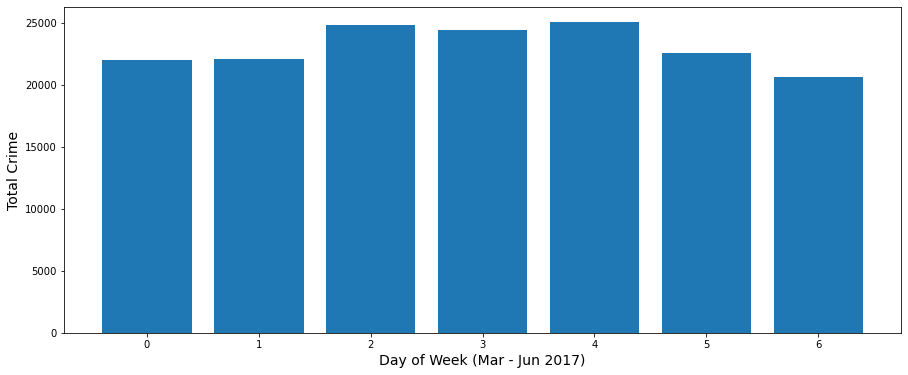

In [36]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2017DOW.DOW, Crime2017DOW.total)
plt.xticks(Crime2017DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2017)', fontsize=14)

In [37]:
Crime2017Month = Crime2017.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2017Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,4206,11806,17242,3990,644,37888,46556.724977,5425
1,4,4092,12487,18056,3991,622,39248,46413.047547,5279
2,5,4048,13856,19566,4051,689,42210,46065.447138,5486
3,6,3894,13947,19810,3838,623,42112,45805.009132,5366


Text(0.5, 0, 'Month (Mar - Jun 2017)')

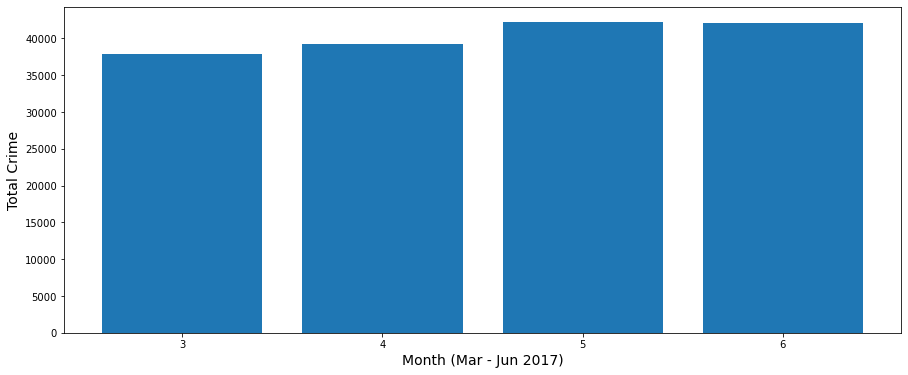

In [38]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2017Month.Month, Crime2017Month.total)
plt.xticks(Crime2017Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2017)', fontsize=14)

In [39]:
Crime2017grouped = Crime2017.groupby(['ZIPCODE', 'Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2017grouped.head(10)

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,3,3,8,10,7,0,28,25.0,16
1,83,4,5,17,25,4,1,52,25.0,24
2,83,5,7,15,29,2,1,54,25.0,26
3,83,6,6,24,39,3,0,72,25.0,27
4,10001,3,30,66,276,23,3,398,22413.0,31
5,10001,4,37,75,282,25,3,422,22413.0,30
6,10001,5,30,97,310,24,3,464,22413.0,31
7,10001,6,27,100,336,17,5,485,22413.0,30
8,10002,3,46,131,192,54,3,426,81305.0,31
9,10002,4,55,148,195,60,1,459,81305.0,30


Crime2017grouped['TotalCrimeNorm'] = Crime2017grouped['total']/(Crime2017grouped['POPULATION']/1000)
Crime2017grouped


In [40]:
Crime2017Apr = Crime2017grouped.loc[(Crime2017grouped['Month'] == 4 )]
Crime2017Apr

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
1,83,4,5,17,25,4,1,52,25.0,24
5,10001,4,37,75,282,25,3,422,22413.0,30
9,10002,4,55,148,195,60,1,459,81305.0,30
13,10003,4,19,68,250,22,2,361,55878.0,30
17,10004,4,28,32,60,20,0,140,2187.0,84
...,...,...,...,...,...,...,...,...,...,...
745,11691,4,49,125,116,24,7,321,60267.0,30
749,11692,4,14,37,36,12,0,99,18018.0,28
753,11693,4,76,112,140,40,0,368,11052.0,104
757,11694,4,3,15,23,4,1,46,20163.0,26


In [41]:
min(Crime2017Apr['POPULATION']), max(Crime2017Apr['POPULATION'])

(0.0, 109069.0)

In [42]:
sanityindex = (Crime2017Apr['POPULATION'] > 1000)
Crime2017Apr = Crime2017Apr.loc[sanityindex]

In [43]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2017Apr['other crim'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2017Apr['personal c'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2017Apr['property c'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2017Apr['statutory'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2017Apr['traffic cr'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2017Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,1.650828,3.346272,12.581984,1.115424,0.133851
10002,0.676465,1.820306,2.398376,0.737962,0.012299
10003,0.340026,1.216937,4.474033,0.393715,0.035792
10004,12.802926,14.631916,27.434842,9.144947,0.000000
10005,0.370051,0.616751,1.356852,0.370051,0.000000
...,...,...,...,...,...
11691,0.813049,2.074104,1.924768,0.398228,0.116150
11692,0.777001,2.053502,1.998002,0.666001,0.000000
11693,6.876583,10.133912,12.667391,3.619254,0.000000


In [44]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.8925513670326678
For n_clusters =3, the average silhouette_score is :0.8291635816579936
For n_clusters =4, the average silhouette_score is :0.46949006240841784
For n_clusters =5, the average silhouette_score is :0.47447479630239325
For n_clusters =6, the average silhouette_score is :0.42434799604886203
For n_clusters =7, the average silhouette_score is :0.42339726693871443
For n_clusters =8, the average silhouette_score is :0.3913181886612355
For n_clusters =9, the average silhouette_score is :0.39025846756866023
For n_clusters =10, the average silhouette_score is :0.30612321388661556
For n_clusters =11, the average silhouette_score is :0.28418299719462176
For n_clusters =12, the average silhouette_score is :0.31125252954902927
For n_clusters =13, the average silhouette_score is :0.27994097973039306
For n_clusters =14, the average silhouette_score is :0.3079586098047798
For n_clusters =15, the average silhouette_score is :0.29389009

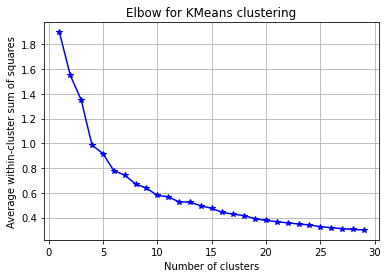

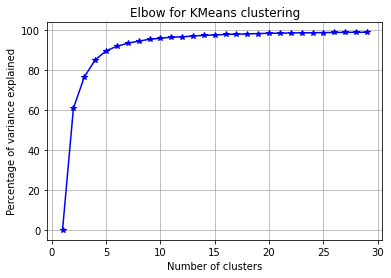

In [45]:
elbow(Crime_ScaledApr, range(1,30))

In [46]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 5, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

4

In [47]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,3
1,10002,4
2,10003,0
3,10004,1
4,10005,4
...,...,...
177,11691,4
178,11692,4
179,11693,2
180,11694,4


In [48]:
clusterCrime2017Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2017Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,1.650828,3.346272,12.581984,1.115424,0.133851,10001,3
1,0.676465,1.820306,2.398376,0.737962,0.012299,10002,4
2,0.340026,1.216937,4.474033,0.393715,0.035792,10003,0
3,12.802926,14.631916,27.434842,9.144947,0.000000,10004,1
4,0.370051,0.616751,1.356852,0.370051,0.000000,10005,4
...,...,...,...,...,...,...,...
177,0.813049,2.074104,1.924768,0.398228,0.116150,11691,4
178,0.777001,2.053502,1.998002,0.666001,0.000000,11692,4
179,6.876583,10.133912,12.667391,3.619254,0.000000,11693,2
180,0.148787,0.743937,1.140703,0.198383,0.049596,11694,4


In [49]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [50]:
clusterCrime2017AprPlot = zips.merge(clusterCrime2017Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2017AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",1.650828,3.346272,12.581984,1.115424,0.133851,3
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",0.676465,1.820306,2.398376,0.737962,0.012299,4
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",0.340026,1.216937,4.474033,0.393715,0.035792,0
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",12.802926,14.631916,27.434842,9.144947,0.000000,1
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",12.802926,14.631916,27.434842,9.144947,0.000000,1
...,...,...,...,...,...,...,...,...,...
189,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",6.876583,10.133912,12.667391,3.619254,0.000000,2
190,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",6.876583,10.133912,12.667391,3.619254,0.000000,2
191,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",6.876583,10.133912,12.667391,3.619254,0.000000,2
192,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",0.148787,0.743937,1.140703,0.198383,0.049596,4


In [51]:
clusterCrime2017AprPlot['label'] = clusterCrime2017AprPlot['label'].astype(str)

clusterCrime2017AprPlot = clusterCrime2017AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2017AprPlot

,ZIPCODE,label,geometry
0,10001,3,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,4,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,1,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,1,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,2,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,2,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,2,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,4,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [52]:
clusterCrime2017AprPlot['label'] = clusterCrime2017AprPlot['label'].replace(['0','1','2','3','4'],['Cluster A','Cluster B','Cluster C','Cluster D','Cluster E'])
clusterCrime2017AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster D,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster E,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster A,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster B,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster B,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,Cluster C,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,Cluster C,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,Cluster C,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,Cluster E,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


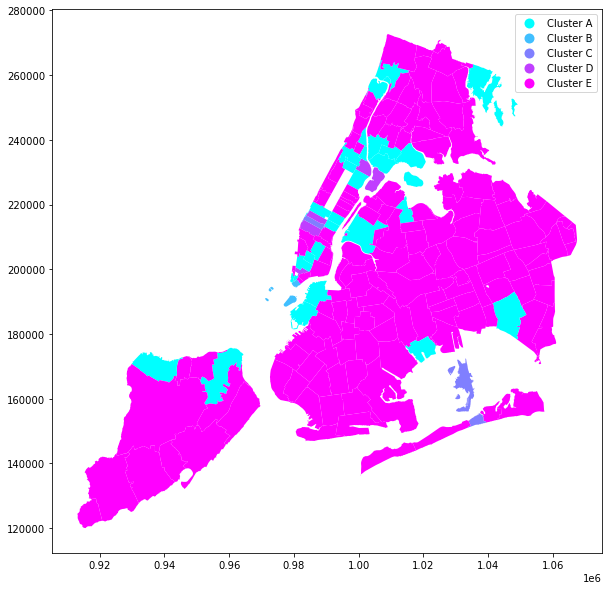

In [53]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2017AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [54]:
clusterCrime2017AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2017AprGraph = clusterCrime2017AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2017AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,26.144687,66.828260,106.415965,24.408147,3.197840,0
1,12.802926,14.631916,27.434842,9.144947,0.000000,1
2,10.692684,20.128461,31.384454,7.617074,0.000000,2
3,8.531647,15.586340,40.702274,10.400544,0.671737,3
4,53.318513,179.866865,252.569623,50.952378,9.378424,4


In [55]:
clusterCrime2017AprGraph

clusterCrime2017AprGraph2 = clusterCrime2017AprGraph[[col for col in clusterCrime2017AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2017AprGraph2 = clusterCrime2017AprGraph2.div(clusterCrime2017AprGraph2.sum(axis=1), axis=0)
clusterCrime2017AprGraph2['label'] = [0,1,2,3,4]
clusterCrime2017AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.115177,0.294404,0.468803,0.107527,0.014088,0
1,0.200000,0.228571,0.428571,0.142857,0.000000,1
2,0.153141,0.288280,0.449488,0.109092,0.000000,2
3,0.112417,0.205374,0.536315,0.137043,0.008851,3
4,0.097638,0.329375,0.462509,0.093305,0.017174,4


In [56]:
clusterCrime2017AprGraph2['label'] = clusterCrime2017AprGraph2['label'].astype(str)

clusterCrime2017AprGraph2['label'] = clusterCrime2017AprGraph2['label'].replace(['0','1','2','3','4'],['Cluster A','Cluster B','Cluster C','Cluster D','Cluster E'])

clusterCrime2017AprGraph2 = clusterCrime2017AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2017AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.115177,0.294404,0.468803,0.107527,0.014088,Cluster A
1,0.200000,0.228571,0.428571,0.142857,0.000000,Cluster B
2,0.153141,0.288280,0.449488,0.109092,0.000000,Cluster C
3,0.112417,0.205374,0.536315,0.137043,0.008851,Cluster D
4,0.097638,0.329375,0.462509,0.093305,0.017174,Cluster E


In [57]:
clusterCrime2017AprGraph2.set_index('label', inplace=True)

Text(0, 0.5, 'Crime Types')

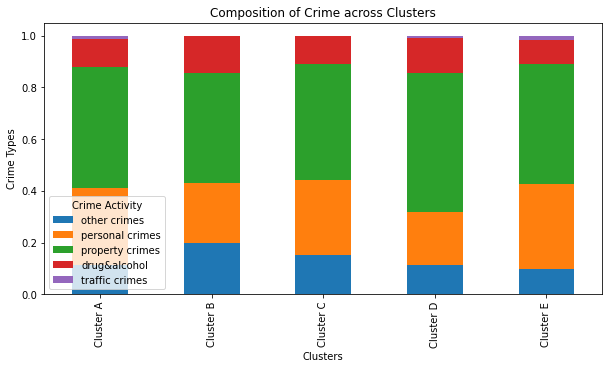

In [58]:
ax = clusterCrime2017AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")

# Crime 2018 Data

In [59]:
Crime2018 = gpd.read_file("Data\clean_data\complaint2018Count\complaint2018Count.shp")

Crime2018['ZIPCODE'] = Crime2018['ZIPCODE'].astype(int)
Crime2018['date'] = pd.to_datetime(Crime2018['date'])

Crime2018['Month'] = Crime2018['date'].dt.month
Crime2018['DOW'] = Crime2018['date'].dt.dayofweek
Crime2018.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2018-03-01,10001,2,6,9,1,0,18,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,3
1,2018-03-02,10001,1,3,10,1,0,15,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,4
2,2018-03-03,10001,1,2,19,1,0,23,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,5
3,2018-03-04,10001,2,2,13,1,0,18,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,6
4,2018-03-05,10001,2,3,10,1,0,16,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,0


In [60]:
Crime2018DOW = Crime2018.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2018DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1889,7567,10403,1653,246,21758,46447.651723,2989
1,1,2283,7413,10421,2037,196,22350,46411.653409,2992
2,2,2411,7318,10448,2015,224,22416,46078.245864,3022
3,3,2614,7992,11418,2177,272,24473,46080.970625,3200
4,4,2597,8394,12188,2222,357,25758,45705.385043,3236
5,5,2258,8397,10792,1858,575,23880,45968.986533,3193
6,6,1760,8134,9151,1547,546,21138,46954.866144,2936


Text(0.5, 0, 'Day of Week (Mar - Jun 2018)')

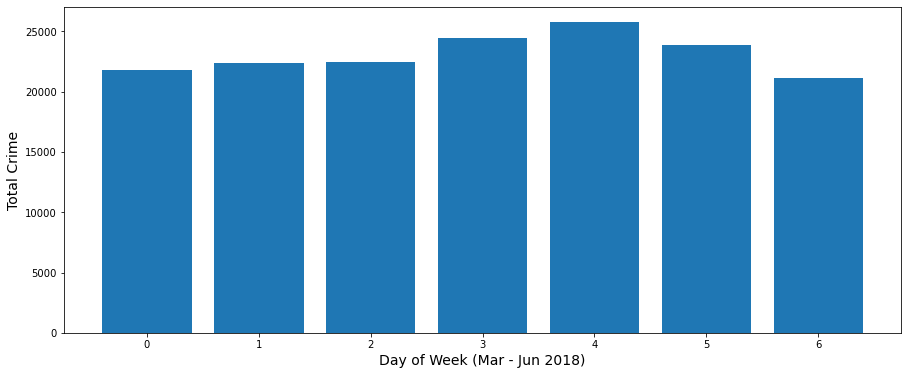

In [61]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2018DOW.DOW, Crime2018DOW.total)
plt.xticks(Crime2018DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2018)', fontsize=14)

In [62]:
Crime2018Month = Crime2018.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2018Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,4137,12801,17559,3624,653,38774,46734.027474,5387
1,4,3846,12974,17931,3537,594,38882,46364.672971,5287
2,5,4077,15042,19624,3419,577,42739,45884.722172,5525
3,6,3752,14398,19707,2929,592,41378,45920.102067,5369


Text(0.5, 0, 'Month (Mar - Jun 2018)')

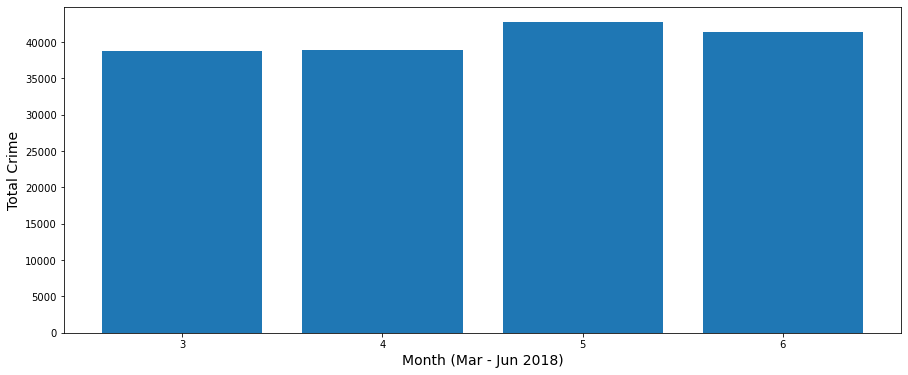

In [63]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2018Month.Month, Crime2018Month.total)
plt.xticks(Crime2018Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2018)', fontsize=14)

In [64]:
Crime2018grouped = Crime2018.groupby(['ZIPCODE', 'Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2018grouped.head(10)

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,3,5,6,13,0,0,24,25.0,16
1,83,4,3,16,22,3,0,44,25.0,22
2,83,5,3,19,24,4,0,50,25.0,24
3,83,6,9,15,20,6,0,50,25.0,20
4,10001,3,45,90,328,33,1,497,22413.0,31
5,10001,4,46,98,314,36,2,496,22413.0,30
6,10001,5,47,87,366,26,1,527,22413.0,31
7,10001,6,22,101,369,24,1,517,22413.0,30
8,10002,3,49,123,214,34,3,423,81305.0,31
9,10002,4,31,154,185,38,2,410,81305.0,30


In [65]:
Crime2018Apr = Crime2018grouped.loc[(Crime2018grouped['Month'] == 4 )]
Crime2018Apr

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
1,83,4,3,16,22,3,0,44,25.0,22
5,10001,4,46,98,314,36,2,496,22413.0,30
9,10002,4,31,154,185,38,2,410,81305.0,30
13,10003,4,19,77,235,27,3,361,55878.0,30
17,10004,4,24,64,76,4,0,168,2187.0,96
...,...,...,...,...,...,...,...,...,...,...
745,11691,4,63,136,120,23,3,345,60267.0,30
749,11692,4,17,33,19,8,2,79,18018.0,26
753,11693,4,56,108,156,40,0,360,11052.0,100
757,11694,4,5,24,10,3,2,44,20163.0,24


In [66]:
min(Crime2018Apr['POPULATION']), max(Crime2018Apr['POPULATION'])

(0.0, 109069.0)

In [67]:
sanityindex = (Crime2018Apr['POPULATION'] > 1000)
Crime2018Apr = Crime2018Apr.loc[sanityindex]

In [68]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2018Apr['other crim'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2018Apr['personal c'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2018Apr['property c'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2018Apr['statutory'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2018Apr['traffic cr'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2018Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,2.052380,4.372462,14.009726,1.606211,0.089234
10002,0.381280,1.894102,2.275383,0.467376,0.024599
10003,0.340026,1.378002,4.205591,0.483196,0.053688
10004,10.973937,29.263832,34.750800,1.828989,0.000000
10005,0.000000,0.740101,5.427408,0.616751,0.000000
...,...,...,...,...,...
11691,1.045348,2.256625,1.991139,0.381635,0.049778
11692,0.943501,1.831502,1.054501,0.444000,0.111000
11693,5.066956,9.771987,14.115092,3.619254,0.000000


In [69]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.9010473824542528
For n_clusters =3, the average silhouette_score is :0.8449690786030672
For n_clusters =4, the average silhouette_score is :0.49483482838817894
For n_clusters =5, the average silhouette_score is :0.44017913512975454
For n_clusters =6, the average silhouette_score is :0.4123256859087146
For n_clusters =7, the average silhouette_score is :0.4139550911028418
For n_clusters =8, the average silhouette_score is :0.41700312469012635
For n_clusters =9, the average silhouette_score is :0.33130304117064313
For n_clusters =10, the average silhouette_score is :0.35041428687518605
For n_clusters =11, the average silhouette_score is :0.3309421253612494
For n_clusters =12, the average silhouette_score is :0.3119070428851562
For n_clusters =13, the average silhouette_score is :0.3182122105167078
For n_clusters =14, the average silhouette_score is :0.3143893206653257
For n_clusters =15, the average silhouette_score is :0.305784787052

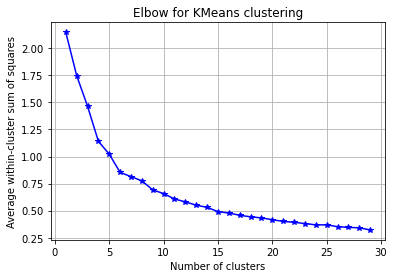

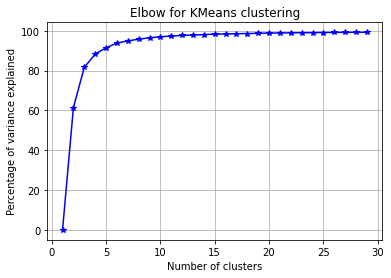

In [70]:
elbow(Crime_ScaledApr, range(1,30))

In [71]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 4, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

3

In [72]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,2
1,10002,0
2,10003,3
3,10004,1
4,10005,3
...,...,...
177,11691,3
178,11692,3
179,11693,2
180,11694,0


In [73]:
clusterCrime2018Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2018Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,2.052380,4.372462,14.009726,1.606211,0.089234,10001,2
1,0.381280,1.894102,2.275383,0.467376,0.024599,10002,0
2,0.340026,1.378002,4.205591,0.483196,0.053688,10003,3
3,10.973937,29.263832,34.750800,1.828989,0.000000,10004,1
4,0.000000,0.740101,5.427408,0.616751,0.000000,10005,3
...,...,...,...,...,...,...,...
177,1.045348,2.256625,1.991139,0.381635,0.049778,11691,3
178,0.943501,1.831502,1.054501,0.444000,0.111000,11692,3
179,5.066956,9.771987,14.115092,3.619254,0.000000,11693,2
180,0.247979,1.190299,0.495958,0.148787,0.099192,11694,0


In [74]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [75]:
clusterCrime2018AprPlot = zips.merge(clusterCrime2018Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2018AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",2.052380,4.372462,14.009726,1.606211,0.089234,2
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",0.381280,1.894102,2.275383,0.467376,0.024599,0
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",0.340026,1.378002,4.205591,0.483196,0.053688,3
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",10.973937,29.263832,34.750800,1.828989,0.000000,1
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",10.973937,29.263832,34.750800,1.828989,0.000000,1
...,...,...,...,...,...,...,...,...,...
189,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",5.066956,9.771987,14.115092,3.619254,0.000000,2
190,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",5.066956,9.771987,14.115092,3.619254,0.000000,2
191,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",5.066956,9.771987,14.115092,3.619254,0.000000,2
192,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",0.247979,1.190299,0.495958,0.148787,0.099192,0


In [76]:
clusterCrime2018AprPlot['label'] = clusterCrime2018AprPlot['label'].astype(str)

clusterCrime2018AprPlot = clusterCrime2018AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2018AprPlot

,ZIPCODE,label,geometry
0,10001,2,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,3,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,1,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,1,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,2,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,2,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,2,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,0,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [77]:
clusterCrime2018AprPlot['label'] = clusterCrime2018AprPlot['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])
clusterCrime2018AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster C,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster A,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster D,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster B,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster B,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,Cluster C,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,Cluster C,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,Cluster C,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,Cluster A,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


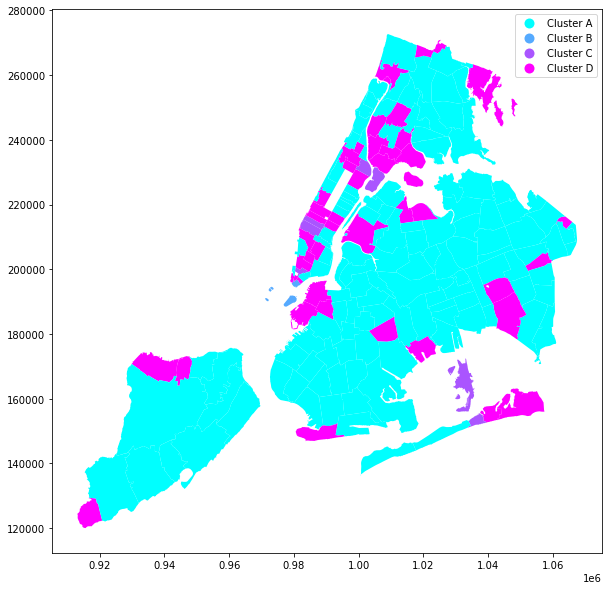

In [78]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2018AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [79]:
clusterCrime2018AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2018AprGraph = clusterCrime2018AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2018AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,42.924803,152.336215,216.538509,38.161943,7.980812,0
1,10.973937,29.263832,34.750800,1.828989,0.000000,1
2,16.102274,36.077046,74.110554,14.138584,0.796669,2
3,31.708887,109.528507,153.720948,31.653605,5.584084,3


In [80]:
clusterCrime2018AprGraph

clusterCrime2018AprGraph2 = clusterCrime2018AprGraph[[col for col in clusterCrime2018AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2018AprGraph2 = clusterCrime2018AprGraph2.div(clusterCrime2018AprGraph2.sum(axis=1), axis=0)
clusterCrime2018AprGraph2['label'] = [0,1,2,3]
clusterCrime2018AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.093734,0.332654,0.472851,0.083334,0.017428,0
1,0.142857,0.380952,0.452381,0.023810,0.000000,1
2,0.114018,0.255458,0.524769,0.100114,0.005641,2
3,0.095452,0.329710,0.462742,0.095286,0.016810,3


In [81]:
clusterCrime2018AprGraph2['label'] = clusterCrime2018AprGraph2['label'].astype(str)

clusterCrime2018AprGraph2['label'] = clusterCrime2018AprGraph2['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])

clusterCrime2018AprGraph2 = clusterCrime2018AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2018AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.093734,0.332654,0.472851,0.083334,0.017428,Cluster A
1,0.142857,0.380952,0.452381,0.023810,0.000000,Cluster B
2,0.114018,0.255458,0.524769,0.100114,0.005641,Cluster C
3,0.095452,0.329710,0.462742,0.095286,0.016810,Cluster D


In [82]:
clusterCrime2018AprGraph2.set_index('label', inplace=True)

Text(0, 0.5, 'Crime Types')

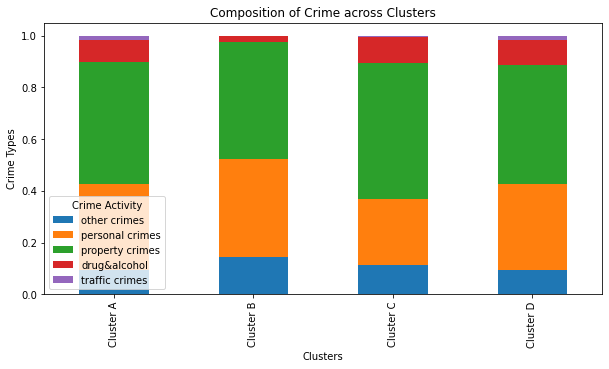

In [83]:
ax = clusterCrime2018AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")

# Crime 2019 Data

In [84]:
Crime2019 = gpd.read_file("Data\clean_data\complaint2019Count\complaint2019Count.shp")

Crime2019['ZIPCODE'] = Crime2019['ZIPCODE'].astype(int)
Crime2019['date'] = pd.to_datetime(Crime2019['date'])

Crime2019['Month'] = Crime2019['date'].dt.month
Crime2019['DOW'] = Crime2019['date'].dt.dayofweek
Crime2019.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2019-03-01,10001,0,2,6,0,0,8,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,4
1,2019-03-02,10001,2,1,10,1,0,14,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,5
2,2019-03-03,10001,1,0,6,0,0,7,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,6
3,2019-03-04,10001,0,0,10,0,0,10,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,0
4,2019-03-05,10001,0,2,6,3,0,11,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,1


In [85]:
Crime2019DOW = Crime2019.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2019DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1899,7600,9973,1487,247,21206,45838.255937,3032
1,1,2198,7524,10327,1869,187,22105,46363.060293,3002
2,2,2449,7856,10683,2122,212,23322,46060.581872,3023
3,3,2224,7401,10306,1887,225,22043,46127.688476,3011
4,4,2528,8363,11684,2013,342,24930,45844.156656,3230
5,5,2226,8830,10523,1560,501,23640,45984.168437,3200
6,6,1856,8541,9300,1308,503,21508,46466.793772,3147


Text(0.5, 0, 'Day of Week (Mar - Jun 2019)')

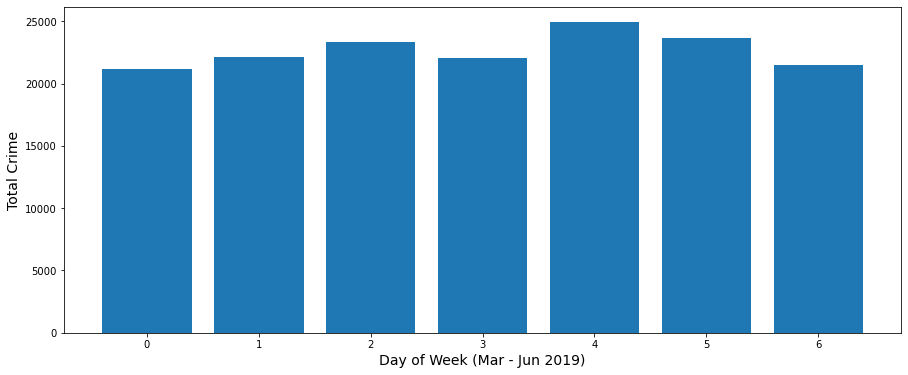

In [86]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2019DOW.DOW, Crime2019DOW.total)
plt.xticks(Crime2019DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2019)', fontsize=14)

In [87]:
Crime2019Month = Crime2019.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2019Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,3978,13023,17147,3018,593,37759,46670.352334,5421
1,4,3782,13226,17184,3022,515,37729,46103.092809,5312
2,5,3906,15079,19062,3210,565,41822,45717.200108,5552
3,6,3714,14787,19403,2996,544,41444,45901.225560,5360


Text(0.5, 0, 'Month (Mar - Jun 2019)')

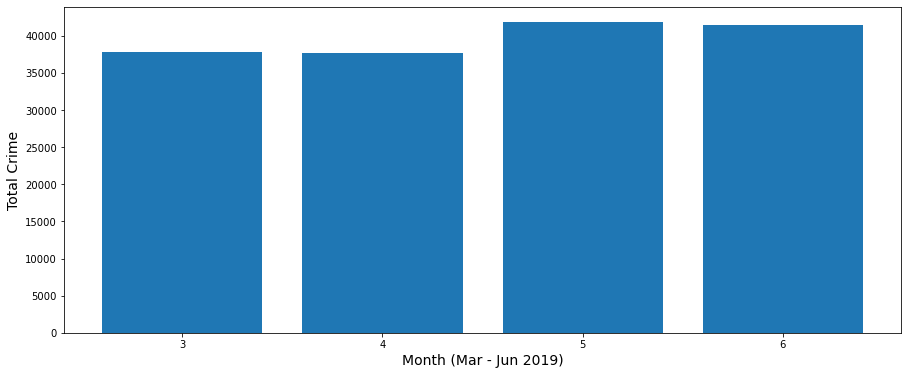

In [88]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2019Month.Month, Crime2019Month.total)
plt.xticks(Crime2019Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2019)', fontsize=14)

In [89]:
Crime2019grouped = Crime2019.groupby(['ZIPCODE', 'Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2019grouped.head(10)

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,3,0,15,16,3,1,35,25.0,21
1,83,4,4,22,29,3,0,58,25.0,26
2,83,5,3,26,21,3,2,55,25.0,26
3,83,6,2,22,33,1,0,58,25.0,26
4,10001,3,36,81,331,26,3,477,22413.0,31
5,10001,4,46,83,325,31,6,491,22413.0,30
6,10001,5,18,96,301,39,1,455,22413.0,31
7,10001,6,34,93,348,46,1,522,22413.0,30
8,10002,3,34,173,207,26,4,444,81305.0,31
9,10002,4,48,166,201,28,4,447,81305.0,30


In [90]:
Crime2019Apr = Crime2019grouped.loc[(Crime2019grouped['Month'] == 4 )]
Crime2019Apr

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
1,83,4,4,22,29,3,0,58,25.0,26
5,10001,4,46,83,325,31,6,491,22413.0,30
9,10002,4,48,166,201,28,4,447,81305.0,30
13,10003,4,15,81,215,15,0,326,55878.0,30
17,10004,4,28,64,92,4,0,188,2187.0,100
...,...,...,...,...,...,...,...,...,...,...
741,11691,4,39,165,97,11,3,315,60267.0,30
745,11692,4,11,37,36,6,1,91,18018.0,28
749,11693,4,36,92,88,32,12,260,11052.0,104
753,11694,4,2,37,16,2,1,58,20163.0,25


In [91]:
sanityindex = (Crime2019Apr['POPULATION'] > 1000)
Crime2019Apr = Crime2019Apr.loc[sanityindex]

In [92]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2019Apr['other crim'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2019Apr['personal c'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2019Apr['property c'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2019Apr['statutory'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2019Apr['traffic cr'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2019Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,2.052380,3.703208,14.500513,1.383126,0.267702
10002,0.590370,2.041695,2.472173,0.344382,0.049197
10003,0.268442,1.449587,3.847668,0.268442,0.000000
10004,12.802926,29.263832,42.066758,1.828989,0.000000
10005,0.000000,0.863451,3.207105,0.370051,0.123350
...,...,...,...,...,...
11691,0.647120,2.737817,1.609504,0.182521,0.049778
11692,0.610501,2.053502,1.998002,0.333000,0.055500
11693,3.257329,8.324285,7.962360,2.895404,1.085776


In [93]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.9286046975990682
For n_clusters =3, the average silhouette_score is :0.8234880003568109
For n_clusters =4, the average silhouette_score is :0.5262179893667831
For n_clusters =5, the average silhouette_score is :0.45478071802526343
For n_clusters =6, the average silhouette_score is :0.4239971442857629
For n_clusters =7, the average silhouette_score is :0.4398387570744901
For n_clusters =8, the average silhouette_score is :0.41172376022755425
For n_clusters =9, the average silhouette_score is :0.4140503525868916
For n_clusters =10, the average silhouette_score is :0.3427549567011629
For n_clusters =11, the average silhouette_score is :0.33608255537965664
For n_clusters =12, the average silhouette_score is :0.31183225803858444
For n_clusters =13, the average silhouette_score is :0.3045236351411487
For n_clusters =14, the average silhouette_score is :0.30674610550892845
For n_clusters =15, the average silhouette_score is :0.305472137159

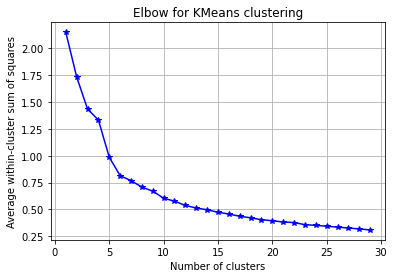

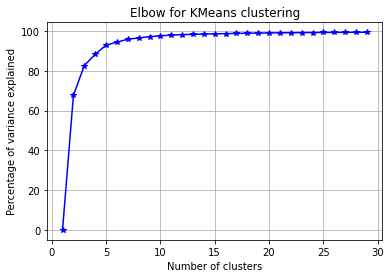

In [94]:
elbow(Crime_ScaledApr, range(1,30))

In [95]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 5, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

4

In [96]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,3
1,10002,4
2,10003,0
3,10004,1
4,10005,0
...,...,...
177,11691,0
178,11692,4
179,11693,3
180,11694,0


In [97]:
clusterCrime2019Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2019Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,2.052380,3.703208,14.500513,1.383126,0.267702,10001,3
1,0.590370,2.041695,2.472173,0.344382,0.049197,10002,4
2,0.268442,1.449587,3.847668,0.268442,0.000000,10003,0
3,12.802926,29.263832,42.066758,1.828989,0.000000,10004,1
4,0.000000,0.863451,3.207105,0.370051,0.123350,10005,0
...,...,...,...,...,...,...,...
177,0.647120,2.737817,1.609504,0.182521,0.049778,11691,0
178,0.610501,2.053502,1.998002,0.333000,0.055500,11692,4
179,3.257329,8.324285,7.962360,2.895404,1.085776,11693,3
180,0.099192,1.835044,0.793533,0.099192,0.049596,11694,0


In [98]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [99]:
clusterCrime2019AprPlot = zips.merge(clusterCrime2019Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2019AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",2.052380,3.703208,14.500513,1.383126,0.267702,3
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",0.590370,2.041695,2.472173,0.344382,0.049197,4
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",0.268442,1.449587,3.847668,0.268442,0.000000,0
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",12.802926,29.263832,42.066758,1.828989,0.000000,1
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",12.802926,29.263832,42.066758,1.828989,0.000000,1
...,...,...,...,...,...,...,...,...,...
189,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",3.257329,8.324285,7.962360,2.895404,1.085776,3
190,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",3.257329,8.324285,7.962360,2.895404,1.085776,3
191,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",3.257329,8.324285,7.962360,2.895404,1.085776,3
192,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",0.099192,1.835044,0.793533,0.099192,0.049596,0


In [100]:
clusterCrime2019AprPlot['label'] = clusterCrime2019AprPlot['label'].astype(str)

clusterCrime2019AprPlot = clusterCrime2019AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2019AprPlot

,ZIPCODE,label,geometry
0,10001,3,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,4,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,1,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,1,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,3,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,3,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,3,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,0,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [101]:
clusterCrime2019AprPlot['label'] = clusterCrime2019AprPlot['label'].replace(['0','1','2','3','4'],['Cluster A','Cluster B','Cluster C','Cluster D','Cluster E'])
clusterCrime2019AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster D,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster E,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster A,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster B,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster B,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,Cluster D,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,Cluster D,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,Cluster D,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,Cluster A,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


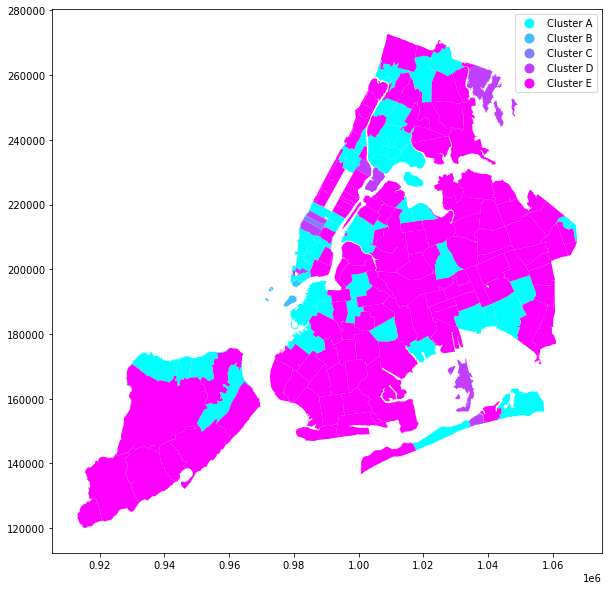

In [102]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2019AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [103]:
clusterCrime2019AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2019AprGraph = clusterCrime2019AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2019AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,33.361041,114.056884,149.185717,29.464555,5.090075,0
1,12.802926,29.263832,42.066758,1.828989,0.000000,1
2,2.907505,14.900963,23.623478,4.361257,0.000000,2
3,13.121657,31.792288,61.533263,15.020223,2.301265,3
4,38.466079,141.373541,186.788647,27.037664,5.908544,4


In [104]:
clusterCrime2019AprGraph

clusterCrime2019AprGraph2 = clusterCrime2019AprGraph[[col for col in clusterCrime2019AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2019AprGraph2 = clusterCrime2019AprGraph2.div(clusterCrime2019AprGraph2.sum(axis=1), axis=0)
clusterCrime2019AprGraph2['label'] = [0,1,2,3,4]
clusterCrime2019AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.100740,0.344418,0.450497,0.088974,0.015371,0
1,0.148936,0.340426,0.489362,0.021277,0.000000,1
2,0.063492,0.325397,0.515873,0.095238,0.000000,2
3,0.106018,0.256869,0.497163,0.121357,0.018593,3
4,0.096268,0.353810,0.467469,0.067666,0.014787,4


In [105]:
clusterCrime2019AprGraph2['label'] = clusterCrime2019AprGraph2['label'].astype(str)

clusterCrime2019AprGraph2['label'] = clusterCrime2019AprGraph2['label'].replace(['0','1','2','3','4'],['Cluster A','Cluster B','Cluster C','Cluster D','Cluster E'])

clusterCrime2019AprGraph2 = clusterCrime2019AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2019AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.100740,0.344418,0.450497,0.088974,0.015371,Cluster A
1,0.148936,0.340426,0.489362,0.021277,0.000000,Cluster B
2,0.063492,0.325397,0.515873,0.095238,0.000000,Cluster C
3,0.106018,0.256869,0.497163,0.121357,0.018593,Cluster D
4,0.096268,0.353810,0.467469,0.067666,0.014787,Cluster E


In [106]:
clusterCrime2019AprGraph2.set_index('label', inplace=True)

Text(0, 0.5, 'Crime Types')

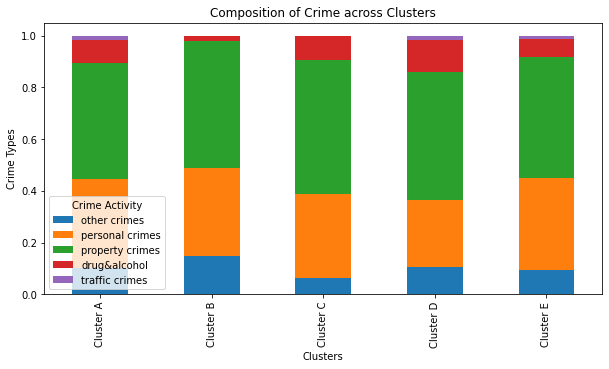

In [107]:
ax = clusterCrime2019AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")